# Pre-requisites

1. Overview and Setup: Follow the resource links to set up an amazon sagemaker studio domain and user profile.<br />

    1. [Domain overview](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-studio-onboard.html)<br />
    1. [Domain quick setup](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html)<br />
    1. [Add/remove domain user profile](https://docs.aws.amazon.com/sagemaker/latest/dg/domain-user-profile-add-remove.html)<br />
    1. [Launch Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-launch.html#studio-launch-console)<br />
    
1. Starting Studio: Follow the steps after both the sagemaker domain and user profile are created.
    1. Go to your user profile and click on the launch button to open the studio.
    1. Next, upload this notebook to the studio with the "Studio File Browser" menu.
    1. Next, Select a sagemaker kernel as the configuration mentioned below:
       1. Image: Base Python 3.0
       1. Kernel: Python 3
       1. Instance type: ml.t3.medium
       1. Start-up script: No script

Now follow through the rest of the notebook to deploy a yolov8 model(ONNX Format) to a sagemaker endpoint serving inference requests with ONNXRuntime.<br />

Hosted inference endpoint can serve inference requests on following ONNXRuntime Execution Providers,<br />
   1. cpu: default CPU Execution Provider (MLAS)
   1. CPU_FP32: Execution on CPU with OpenVino Execution Provider

### Contents

1. [Installation](#Installation)
1. [Imports](#Imports)
1. [Model Conversion and S3 upload](#Model-Conversion-and-S3-upload)
   1. [Pytorch Model Download](#Pytorch-Model-Download)
   1. [Pytorch to ONNX Conversion](#Pytorch-to-ONNX-Conversion)
   1. [ZIP ONNX model](#ZIP-ONNX-model)
   1. [S3 Upload](#S3-Upload)
1. [Model Deployment](#Model-Deployment)
   1. [Instruction To Build](#Instruction-To-Build)
   1. [Deploy the model](#Deploy-the-model)
   1. [Inference](#Inference)
1. [Cleanup](#Cleanup)
1. [Cost Analysis](#Cost-Analysis)
1. [Notices & Disclaimers](#Notices-&-Disclaimers)

# Installation

Run the cells below  to install the packages required for Pytoch to ONNX model conversion.

In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install  sagemaker ultralytics opencv-python

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
  Using cached ultralytics-8.0.109-py3-none-any.whl (591 kB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)


# Imports

Run the cells below to import all necessary packages.

In [3]:
import os

import boto3
import sagemaker
from sagemaker import Model
from sagemaker import Predictor
from sagemaker import get_execution_role

In [4]:
# Below variables are required to access various aws services like s3, ecr & sagemaker. 
role = get_execution_role()

region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

session = sagemaker.Session()
bucket = session.default_bucket() # Default s3 bucket of your sagemaker domain 

print("<role>: ", role)
print("<region>: ", region)
print("<account_id>: ", account_id)
print("<bucket>: ", bucket)

<role>:  arn:aws:iam::196327195270:role/service-role/AmazonSageMaker-ExecutionRole-20220921T133099
<region>:  us-east-1
<account_id>:  196327195270
<bucket>:  sagemaker-us-east-1-196327195270


# Model Conversion and S3 upload

This session performs two operations.<br /> 
First, it downloads the yolo-v8 Pytorch model from the [ultralytics](https://github.com/ultralytics/ultralytics) GitHub repo and performs an ONNX export using the ultralytics YOLO CLI. Then, it zips (as ".tar.gz" file) it and uploads it to the S3.

## Pytorch Model Download

In [28]:
!mkdir -p model
%cd model
!wget https://github.com/roboflow/sagemaker-yolov8/tree/main/yolov8-weights/runs/detect/train -O yolov8n.pt

/root/model
--2023-05-25 19:34:35--  https://github.com/roboflow/sagemaker-yolov8/tree/main/yolov8-weights/runs/detect/train
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘yolov8n.pt’

yolov8n.pt              [ <=>                ] 147.84K  --.-KB/s    in 0.005s  

2023-05-25 19:34:35 (27.0 MB/s) - ‘yolov8n.pt’ saved [151384]



## Pytorch to ONNX Conversion

In [6]:
# Convert pytorch version of YOLOV8 model file to onnx format 
if not os.path.isfile('/home/ec2-user/SageMaker/model/yolov8n.onnx'):
    !yolo mode=export model=yolov8n.pt format=onnx dynamic=True # To get a static model chnage dynamic flag to False
else:
    print("ONNX file alreday exist. Please re-run the cell after removing it.")

/bin/bash: yolo: command not found


In [7]:
!pwd

/root/model


## ZIP ONNX model

In [8]:
# Model needs to be zipped before storing into a S3 bucket
import tarfile
import os


source_files = ['/root/model/yolov8n.onnx']
output_zip_file = '/root/model/model.tar.gz'

if not os.path.isfile(output_zip_file):
    with tarfile.open(output_zip_file, mode="w:gz") as t:
        for sf in source_files:
            t.add(sf, arcname=os.path.basename(sf))
        print(f"ZIP file is created at {output_zip_file} location.")
else:
    print(f"ZIP file '{output_zip_file}' already exist. Please re-run the cell after removing it.")

ZIP file '/root/model/model.tar.gz' already exist. Please re-run the cell after removing it.


## S3 Upload

In [9]:
print("<bucket>: ", bucket)

<bucket>:  sagemaker-us-east-1-196327195270


In [21]:
# Upload the model to default S3 bucket of your sagemaker domain
model_location = session.upload_data(path=output_zip_file, key_prefix='deployment_model')
print(f"Zip file is uploaded to {model_location} location of '{bucket}' S3 bucket.")

Zip file is uploaded to s3://sagemaker-us-east-1-196327195270/deployment_model/model.tar.gz location of 'sagemaker-us-east-1-196327195270' S3 bucket.


# Model Deployment

In this session, we will create a custom service script, container entry point script, and a docker file to deploy the ONNX model to an sagemaker inference endpoint.<br />
Run the below cells to write all these files to a directory called "docker-inference". And instructions to build the image are mentioned in the next part.

In [11]:
# Creating an ECR uri to inference with the build docker image
ecr_repository = 'yolov8-deployment'
tag = ':latest'
uri_suffix = 'amazonaws.com'
inference_repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository + tag)

In [12]:
%cd ..
!mkdir -p docker-inference

/root


In [13]:
%%writefile docker-inference/model_script.py

import os
from datetime import datetime
import requests
import shutil

import torch

# Libraries for pre and post processsing
from ultralytics.yolo.data.augment import LetterBox
from ultralytics.yolo.engine.results import Results
from ultralytics.yolo.utils import ops
# from ultralytics.yolo.utils.plotting import Annotator, colors

# import onnx_runtime related package
import onnxruntime as rt

import numpy as np
import cv2


class ModelHandler(object):
    """
    A YOLOV8 Model handler implementation.
    """
    def __init__(self):
        
        self.initialized = False

        # Parameters for inference
        self.mlas_model = None
        self.ov_model = None
        self.input_names = None
        self.output_names = None

        # Parameters for pre-processing
        self.imgsz = 640 # default value for this usecase. 
        self.stride = 32 # default value for this usecase( differs based on the model selected )
        
        # Parameters for post-processing
        self.conf = 0.25
        self.iou = 0.45
        self.max_det = 300
        self.classes = None
        self.agnostic = False
        self.labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
        
        self.path = '/home/raw-data/'

    def initialize(self, context):
        
        self.initialized = True
        properties = context.system_properties
        model_dir = properties.get("model_dir")
        
        so = rt.SessionOptions()
        self.mlas_model = rt.InferenceSession(os.path.join(model_dir,'yolov8n.onnx'), so, providers=['CPUExecutionProvider'])
        self.ov_model = rt.InferenceSession(os.path.join(model_dir,'yolov8n.onnx'), so, providers=['OpenVINOExecutionProvider'], provider_options=[{'device_type' : 'CPU_FP32'}]) 
        
        self.input_names = self.ov_model.get_inputs()[0].name
        outputs = self.ov_model.get_outputs()
        self.output_names = list(map(lambda output:output.name, outputs))
    
    def preprocess(self, request):
        
        if request and (',' in request[0]['body'].decode()):
            image_url = request[0]['body'].decode().split(',')[0].strip()
            device = request[0]['body'].decode().split(',')[1].strip()
        else:
            print("Inavalid input. Should be a comma seperated string with image url and device type.")
            return

        ## Set up the image URL and filename
        self.path = self.path+image_url.split("/")[-1] if self.path == '/home/raw-data/' else '/home/raw-data/'+image_url.split("/")[-1]
        # self.path = self.path+self.filename if self.path=='' else

        # Open the url image, set stream to True, this will return the stream content.
        r = requests.get(image_url, stream = True)

        # Check if the image was retrieved successfully
        if r.status_code == 200:
            # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
            r.raw.decode_content = True

            # Open a local file with wb ( write binary ) permission.
            with open(self.path,'wb') as f:
                shutil.copyfileobj(r.raw, f)

            print('Image sucessfully downloaded: ',self.path)
        else:
            print('Image couldn\'t be retreived')
            return
        
        image_abs_path = os.path.abspath(self.path)
        if os.path.isfile(image_abs_path) and image_abs_path.split('.')[-1].lower() in ['jpg', 'jpeg', 'png']:

            # Load Image
            img0 = cv2.imread(image_abs_path)

            # Padded resize
            img = LetterBox(self.imgsz, True, stride=self.stride)(image=img0.copy())

            # Convert
            img =  img.transpose((2, 0, 1))[::-1]  # BGR to RGB, to 3x416x416
            img = np.ascontiguousarray(img)

            img = img.astype(np.float32)  # uint8 to fp16/32
            img /= 255.0  # 0 - 255 to 0.0 - 1.0
        
            if img.ndim == 3:
                img = np.expand_dims(img, axis=0)
            return img0, img, device
        else:
            print("Invalid image format.")
            return

    def inference(self, model_input, device):
        if device == 'cpu':
            print("Performing ONNX Runtime Inference with default CPU EP.")
            start_time = datetime.now()
            prediction = self.mlas_model.run(self.output_names, {self.input_names: model_input})
            end_time = datetime.now()
        elif device == 'CPU_FP32':
            print("Performing ONNX Runtime Inference with OpenVINO CPU EP.")
            start_time = datetime.now()
            prediction = self.ov_model.run(self.output_names, {self.input_names: model_input})
            end_time = datetime.now()
        else:
            print("Invalid Device Option. Supported device options are 'cpu', 'CPU_FP32'.")
            return None
        return prediction, (end_time - start_time).total_seconds()

    def postprocess(self, img0, img, inference_output):
        if inference_output is not None:
            prediction = inference_output[0]
            inference_time = inference_output[1]

            prediction = [torch.from_numpy(pred) for pred in prediction]
            preds = ops.non_max_suppression(prediction,
                                                    self.conf,
                                                    self.iou,
                                                    agnostic=self.agnostic,
                                                    max_det=self.max_det,
                                                    classes=self.classes)
            log_string = ''
            results = []
            for _, pred in enumerate(preds):
                pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], img0.shape).round()
                results.append(Results(img0, self.path, self.labels, boxes=pred))

            det = results[0].boxes
            if len(det) == 0:
                return log_string+'No detection found.'
            for c in det.cls.unique():
                n = (det.cls == c).sum()  # detections per class
                log_string += f"{n} {self.labels[int(c)]}{'s' * (n > 1)}, "

            raw_output = ''
            # annotator = Annotator(img0, pil=False)
            for d in reversed(det):
                cls, conf = d.cls.squeeze(), d.conf.squeeze()
                c = int(cls)  # integer class
                name = f'id:{int(d.id.item())} {self.labels[c]}' if d.id is not None else self.labels[c]
                # label = f'{name} {conf:.2f}'
                box = d.xyxy.squeeze().tolist()
                p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
                raw_output+=f"name: {name}, confidence: {conf:.2f}, start_point: {p1}, end_point:{p2}\n"
                # annotator.box_label(d.xyxy.squeeze(), label, color=colors(c, True))

            # result_img = annotator.result()

            return [f"inference_time: {inference_time}s\nInference_summary: {log_string}\nraw_output:\n{raw_output}"]
        return None

    def handle(self, data, context):
        preprocessed_data = self.preprocess(data)
        if preprocessed_data:
            org_input, model_input, device = preprocessed_data
            inference_output = self.inference(model_input, device)
        return self.postprocess(org_input, model_input, inference_output)

_service = ModelHandler()

def handle(data, context):
    if not _service.initialized:
        _service.initialize(context)
    
    if data is None:
        return None

    return _service.handle(data, context)

Overwriting docker-inference/model_script.py


In [15]:
%%writefile docker-inference/dockerd-entrypoint.py

import subprocess
import sys
import shlex
import os
from retrying import retry
from subprocess import CalledProcessError
from sagemaker_inference import model_server

def _retry_if_error(exception):
    return isinstance(exception, CalledProcessError or OSError)

@retry(stop_max_delay=1000 * 50,
       retry_on_exception=_retry_if_error)
def _start_mms():
    # by default the number of workers per model is 1, but we can configure it through the
    # environment variable below if desired.
    # os.environ['SAGEMAKER_MODEL_SERVER_WORKERS'] = '2'
    model_server.start_model_server(handler_service='/home/model-server/model_script.py:handle')

def main():
    if sys.argv[1] == 'serve':
        _start_mms()
    else:
        subprocess.check_call(shlex.split(' '.join(sys.argv[1:])))

    # prevent docker exit
    subprocess.call(['tail', '-f', '/dev/null'])
    
main()

Overwriting docker-inference/dockerd-entrypoint.py


In [16]:
%%writefile docker-inference/Dockerfile

FROM ubuntu:20.04

# Set a docker label to advertise multi-model support on the container
LABEL com.amazonaws.sagemaker.capabilities.multi-models=true
# Set a docker label to enable container to use SAGEMAKER_BIND_TO_PORT environment variable if present
LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true

# Install necessary dependencies for MMS and SageMaker Inference Toolkit
RUN apt-get update && \
    apt-get -y install --no-install-recommends \
    build-essential \
    ca-certificates \
    openjdk-8-jdk-headless \
    python3-dev \
    curl \
    vim \
    && rm -rf /var/lib/apt/lists/* \
    && curl -O https://bootstrap.pypa.io/get-pip.py \
    && python3 get-pip.py

RUN update-alternatives --install /usr/bin/python python /usr/bin/python3 1
RUN update-alternatives --install /usr/local/bin/pip pip /usr/local/bin/pip3 1

RUN apt-get update
RUN DEBIAN_FRONTEND=noninteractive apt-get install ffmpeg libsm6 libxext6 -y

RUN pip3 install requests opencv-contrib-python ultralytics onnxruntime-openvino multi-model-server \
                sagemaker-inference retrying

COPY dockerd-entrypoint.py /usr/local/bin/dockerd-entrypoint.py
RUN chmod +x /usr/local/bin/dockerd-entrypoint.py

RUN mkdir -p /home/model-server/

# Copy the custom service file to handle incoming data and inference requests
COPY model_script.py /home/model-server/model_script.py

RUN mkdir -p /home/raw-data/
RUN chmod +rwx /home/raw-data/

# Entrypoint script for the docker image
ENTRYPOINT ["python3", "/usr/local/bin/dockerd-entrypoint.py"]

# Command to be passed to the entrypoint
CMD ["serve"]

Overwriting docker-inference/Dockerfile


## Instruction To Build

This step needs to be manually carried out in an AWS EC2 instance. To build the image, download the "docker-inference" folder from "File Browser" section and follows the commands mentioned below. <br />
1. Build the image with `ecr_repository` tag. <br />
    `sudo docker build -t <ecr_repository> docker-inference/`<br />
1. Re tag the image with `inference_repository_uri` name. <br />
    `sudo docker tag <ecr_repository> <inference_repository_uri>`<br />
1. Create an AWS ECR and login into to push the image. <br />
    1. `aws ecr get-login-password --region <region> | sudo docker login --username AWS --password-stdin <account_id>.dkr.ecr.<region>.amazonaws.com`<br />
    1. `aws ecr create-repository --repository-name <ecr_repository>` # Need to create only once<br />
    1. `sudo docker push <inference_repository_uri>`<br />
    
Note: Part of command enclosed in `<>` refers to a variable, which needs to be replaced with their actual value. Run the cell below to get the actual value of these variable.

In [17]:
print("<ecr_repository>: ", ecr_repository)
print("<inference_repository_uri>: ", inference_repository_uri)
print("<region>: ", region)
print("<account_id>: ", account_id)

<ecr_repository>:  yolov8-deployment
<inference_repository_uri>:  196327195270.dkr.ecr.us-east-1.amazonaws.com/yolov8-deployment:latest
<region>:  us-east-1
<account_id>:  196327195270


For more information follow [here](https://docs.aws.amazon.com/AmazonECR/latest/userguide/getting-started-cli.html).

## Deploy the model

Now, run the cells below two deploy the model to a sagemaker endpoint. The instance size used for deployment is of type 'ml.c6i.xlarge'.

Note: Make sure the image is built and pushed to ecr before trying out this part.

In [22]:
ENDPOINT_NAME = "YOLO-V8-DEPLOYMENT-1"

In [24]:
yolo_model = Model(
                   model_data=model_location,
                   role=role,
                   image_uri=inference_repository_uri,
                   name='YOLO-V8-deployment-1')

In [25]:
yolo_model.deploy(initial_instance_count=1, instance_type='ml.c6i.2xlarge', endpoint_name=ENDPOINT_NAME)

------------!

Now our model is deployed to the specified endpoint and ready to serve for inference request, follow the next part to perform inference request.

## Inference

Run the cells below to perform inference on input data. Make sure the input data used for inference should be in the format of "image_url,device_type". Where supported image types are 'jpg', 'jpeg', 'png' and device types are 'cpu' & 'CPU_FP32'.<br />

Passing 'cpu' as device type will perform the ONNXRuntime inference with default CPU EP(MLAS), whereas passing 'CPU_FP32' will perform the ONNXRuntime inference with OpenVINO EP.

In [19]:
ENDPOINT_NAME = "YOLO-V8-DEPLOYMENT"

In [20]:
predictor = Predictor(endpoint_name=ENDPOINT_NAME)

In [21]:
# Need to display the prediction result
import cv2 as cv
from ultralytics.yolo.utils.plotting import colors
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def display(filename, labels, points, confidences, class_to_idx, plot_title):

    img0 = cv.imread(filename)
    img0 = cv.cvtColor(img0, cv.COLOR_BGR2RGB)

    # Default values for this usecase
    lw = max(round(sum(img0.shape) / 2 * 0.003), 2) # line width
    txt_color=(255, 255, 255)
    tf = max(lw - 1, 1)  # font thickness

    for i in range(len(labels)):
        label = labels[i]
        p1, p2 = points[i][0], points[i][1]
        color = colors(class_to_idx[label], True)
        cv.rectangle(img0, p1, p2, color, thickness=lw, lineType=cv.LINE_AA)
        w, h = cv.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv.rectangle(img0, p1, p2, color, -1, cv.LINE_AA)  # filled
        cv.putText(img0,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv.LINE_AA)

    plt.title(label=plot_title,
              fontsize=10,
              color="green")
    plt.axis('off')
    plt.imshow(img0)
    plt.show()

In [29]:
# Downloading the image for displaying purpose
!wget https://github.com/roboflow/sagemaker-yolov8/blob/main/yolov8-weights/runs/detect/predict/dog.jpeg -O dog.jpg

idx_to_class = {0: 'dog', 1: 'person', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'} 
class_to_idx = {}
for key, val in idx_to_class.items():
    if val not in class_to_idx.keys():
        class_to_idx[val] = int(key)

--2023-05-25 19:35:22--  https://github.com/roboflow/sagemaker-yolov8/blob/main/yolov8-weights/runs/detect/predict/dog.jpeg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dog.jpg’

dog.jpg                 [ <=>                ] 138.72K  --.-KB/s    in 0.008s  

2023-05-25 19:35:23 (16.7 MB/s) - ‘dog.jpg’ saved [142046]



In [24]:
# Change the num_iter_steps and warmup_steps based on the requirement
num_iter_steps = 1000
warmup_steps = 20

Run cells below to perform ONNXRuntime inference with default CPU execution provider. 

In [25]:
payload1 = "https://github.com/roboflow/sagemaker-yolov8/blob/main/yolov8-weights/runs/detect/predict/dog.jpeg,cpu"


# warmup steps
for _ in range(warmup_steps):
    predictor.predict(payload1)

!sleep 10

total_latency = 0
for _ in range(num_iter_steps):
    response1 = predictor.predict(payload1)
    total_latency += float(response1.decode().split('\n')[0].split(':')[1][:-1].strip())

print("(Default CPU EP) Avg Latency In Seconds: ", total_latency/num_iter_steps)
print("\nSingle Inference Results:\n",response1.decode())

(Default CPU EP) Avg Latency In Seconds:  0.034997729

Single Inference Results:
 inference_time: 0.038578s
Inference_summary: 4 persons, 1 bus, 1 stop sign, 
raw_output:
name: person, confidence: 0.30, start_point: (0, 551), end_point:(67, 874)
name: stop sign, confidence: 0.35, start_point: (0, 255), end_point:(32, 325)
name: person, confidence: 0.82, start_point: (221, 406), end_point:(345, 857)
name: person, confidence: 0.85, start_point: (670, 380), end_point:(810, 876)
name: person, confidence: 0.87, start_point: (49, 399), end_point:(245, 903)
name: bus, confidence: 0.87, start_point: (17, 231), end_point:(802, 768)



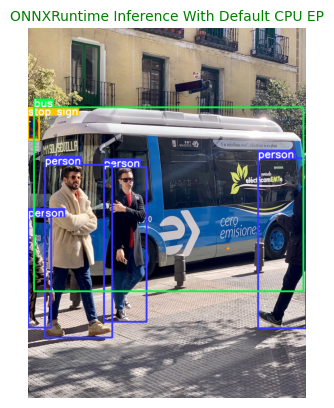

In [26]:
# Dsiplay the output
# update the labels, points and confidences with your inference output 
labels1 = ['dog', 'person', 'car']
points1 = [[(0, 551), (67, 874)], [(0, 255), (32, 325)], [(221, 406), (345, 857)], [(670, 380), (810, 876)], [(49, 399), (245, 903)], [(17, 231), (802, 768)]]
confidences1 = [0.30, 0.35, 0.82, 0.85, 0.87, 0.87]

display('bus.jpg', labels1, points1, confidences1, class_to_idx, 'ONNXRuntime Inference With Default CPU EP')

Run cells below to perform ONNXRuntime inference with OpenVINO execution provider. 

In [27]:
payload2 = "https://github.com/roboflow/sagemaker-yolov8/blob/main/yolov8-weights/runs/detect/predict/dog.jpeg,CPU_FP32"

# warmup steps
for _ in range(warmup_steps):
    predictor.predict(payload2)

!sleep 10 

total_latency = 0
for _ in range(num_iter_steps):
    response2 = predictor.predict(payload2)
    total_latency += float(response2.decode().split('\n')[0].split(':')[1][:-1].strip())

print("(OpenVINO EP) Avg Latency In Seconds: ", total_latency/num_iter_steps)
print("\nSingle Inference Details:\n",response2.decode())

(OpenVINO EP) Avg Latency In Seconds:  0.01805064799999999

Single Inference Details:
 inference_time: 0.017783s
Inference_summary: 4 persons, 1 bus, 1 stop sign, 
raw_output:
name: person, confidence: 0.30, start_point: (0, 551), end_point:(67, 874)
name: stop sign, confidence: 0.35, start_point: (0, 255), end_point:(32, 325)
name: person, confidence: 0.82, start_point: (221, 406), end_point:(345, 857)
name: person, confidence: 0.85, start_point: (670, 380), end_point:(810, 876)
name: person, confidence: 0.87, start_point: (49, 399), end_point:(245, 903)
name: bus, confidence: 0.87, start_point: (17, 231), end_point:(802, 768)



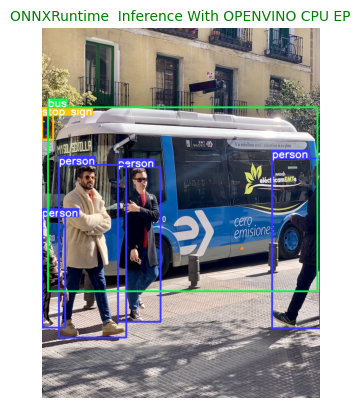

In [28]:
# Dsiplay the output
# update the labels, points and confidences with your inference output 
labels2 = ['person', 'stop sign', 'person', 'person', 'person', 'bus']
points2 = [[(0, 551), (67, 874)], [(0, 255), (32, 325)], [(221, 406), (345, 857)], [(670, 380), (810, 876)], [(49, 399), (245, 903)], [(17, 231), (802, 768)]]
confidences2 = [0.30, 0.35, 0.82, 0.85, 0.87, 0.87]

display('bus.jpg', labels2, points2, confidences2, class_to_idx, 'ONNXRuntime  Inference With OPENVINO CPU EP')

# Cleanup

 Now delete the endpoints to avoid unnecessary charges. For more information on cleanup follow [here](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

In [29]:
predictor.delete_endpoint()

# Cost Analysis

The benchmark results below demonstrate the cost saving comparison of  "OpenVINO Execution provider" over "Default CPU(MLAS) Execution provider". The results may be helpful when deciding which ONNXRuntime is best for your applications.

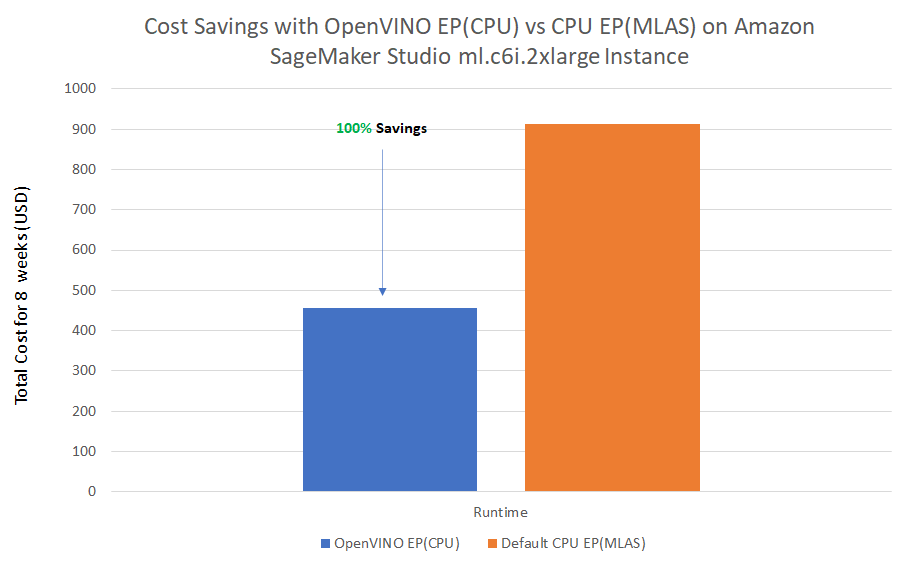

# Notices & Disclaimers

Performance varies by use, configuration and other factors. Learn more at www.Intel.com/PerformanceIndex​.

Your costs and results may vary.

Intel technologies may require enabled hardware, software or service activation.